### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Transformers

#### Self-attention

**Idea of self-attention**

It’s a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should “pay more attention” to some features and “pay less attention” to other features.

Does that sound familiar? You’ve already encountered a similar concept twice in this book:
- Max pooling in convnets looks at a pool of features in a spatial region and selects just one feature to keep. That’s an “all or nothing” form of attention: keep the most important feature and discard the rest.
- TF-IDF normalization assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted while irrelevant tokens get faded out. That’s a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones. How these scores should be computed, and what you should do with them, will vary from approach to approach.

**Why self-attention required**

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. 

You’ve just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. 

In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that’s not quite how language works: the meaning of a word is usually context-specific. 

When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. 

When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” 

And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

**What exactly is self-attention - In Short**

Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That’s where self-attention comes in. 

The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations.

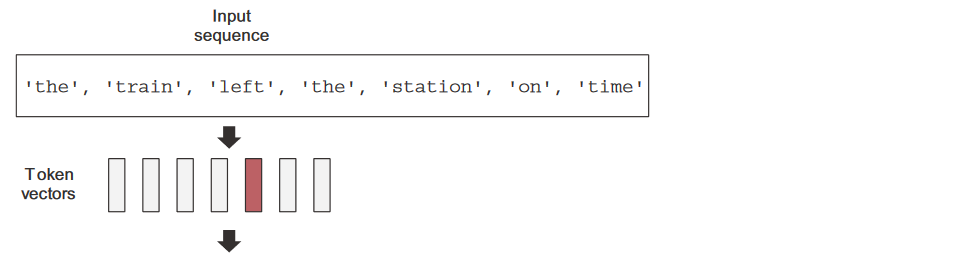

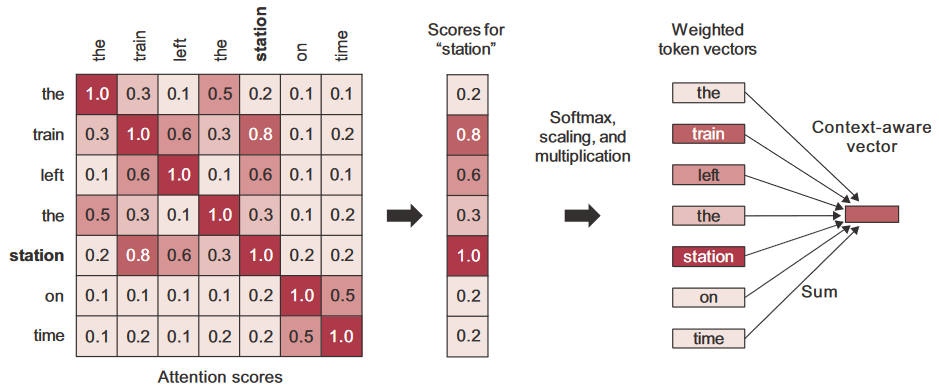

**How to calculate - A Simplified View**

> Step 1

Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. 

These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. 

It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. 

In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.

> Step 2

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. 

Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. 

The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

**Implementation**

```
def self_attention(input_sequence):
    # Initializing the output matrix as the same shape as input_sequence (list of embedding vectors corresponding to the words in the sequence)  
    output = np.zeros(shape=input_sequence.shape)

    # Iterate over each token in the input sequence
    for i, pivot_vector in enumerate(input_sequence):
        # Initializing the score vector (1D - 1 score element for each token)
        scores = np.zeros(shape=(len(input_sequence),))
        # Iterate over each token in the input sequence
        for j, vector in enumerate(input_sequence):
            # Calculating dot product(similarity) between pivot_vector and all the other vectors in the sequence
            # Storing the scores in the list 
            scores[j] = np.dot(pivot_vector, vector.T)
        # Scale by a normalization factor, and apply a softmax
        scores /= np.sqrt(input_sequence.shape[1])
        scores = softmax(scores)
        # Initializing a matrix of the same shape as pivot_vector so that we can store the new representation of the pivot vector calculated similarity scores of other tokens around it  
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            # Take the sum of all tokens weighted by the attention scores
            new_pivot_representation += vector * scores[j]
        # Storing the new final representation of the pivot vector in the proper index as per its position in the input_sequence
        output[i] = new_pivot_representation
    return output
```

In practice you’d use a vectorized implementation. Keras has a built-in layer to handle it: the MultiHeadAttention layer.

```
num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)
```

**Things to understand here**

- Why are we passing the inputs to the layer three times? That seems redundant.
- What are these “multiple heads” we’re referring to? That sounds intimidating-do they also grow back if you cut them?

#### GENERALIZED SELF-ATTENTION: THE QUERY-KEY-VALUE MODEL

So far, we have only considered one input sequence. However, the Transformer architecture was originally developed for machine translation, where you have to deal with two input sequences: the source sequence you’re currently translating (such as “How’s
the weather today?”), and the target sequence you’re converting it to (such as “¿Qué tiempo hace hoy?”). 

A Transformer is a sequence-to-sequence model: it was designed to convert one sequence into another.

The self-attention mechanism as we’ve introduced it performs the following, schematically:

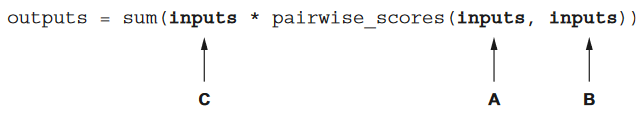

This means “for each token in inputs (A), compute how much the token is related to every token in inputs (B), and use these scores to weight a sum of tokens from inputs (C).” 

Crucially, there’s nothing that requires A, B, and C to refer to the same input sequence. In the general case, you could be doing this with three different sequences. We’ll call them “query,” “keys,” and “values.” 

The operation becomes “for each element in the query, compute how much the element is related to every key, and use these scores to weight a sum of values”:

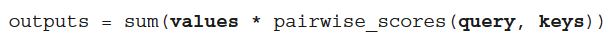

This terminology comes from search engines and recommender systems. 

Imagine that you’re typing up a query to retrieve a photo from your collection—“dogs on the beach.” 

Internally, each of your pictures in the database is described by a set of keywords—“cat,” “dog,” “party,” etc. We’ll call those “keys.” 

The search engine will start by comparing your query to the keys in the database. “Dog” yields a match of 1, and “cat” yields a match of 0. 

It will then rank those keys by strength of match—relevance—and it will return the pictures associated with the top N matches, in order of relevance.

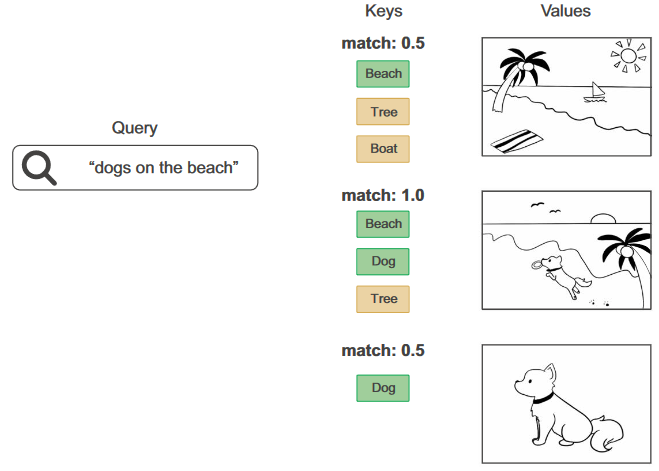

Conceptually, this is what Transformer-style attention is doing. You’ve got a reference sequence that describes something you’re looking for: the query. 

You’ve got a body of knowledge that you’re trying to extract information from: the values. 

Each value is assigned a key that describes the value in a format that can be readily compared to a query. You simply match the query to the keys. Then you return a weighted sum of values.

In practice, the keys and the values are often the same sequence. 

In machine translation, for instance, the query would be the target sequence, and the source sequence would play the roles of both keys and values. 

For each element of the target (like “tiempo”), you want to go back to the source (“How’s the weather today?”) and identify the different bits that are related to it (“tiempo” and “weather” should have a strong match). 

And naturally, if you’re just doing sequence classification, then query, keys, and values are all the same: you’re comparing a sequence to itself, to enrich each token with context from the whole sequence.

#### Multi-head attention

“Multi-head attention” is an extra tweak to the self-attention mechanism, introduced in “Attention is all you need.” 

The “multi-head” moniker refers to the fact that the output space of the self-attention layer gets factored into a set of independent subspaces, learned separately: the initial query, key, and value are sent through three independent sets of dense projections, resulting in three separate vectors.

Each vector is processed via neural attention, and the three outputs are concatenated back together into a single output sequence. Each such subspace is called a “head.

The presence of the learnable dense projections enables the layer to actually learn something, as opposed to being a purely stateless transformation that would require additional layers before or after it to be useful.

In addition, having independent heads helps the layer learn different groups of features for each token, where features within
one group are correlated with each other but are mostly independent from features in a different group.

This is similar in principle to what makes depthwise separable convolutions work: in a depthwise separable convolution, the output space of the convolution is factored into many subspaces (one per input channel) that get learned independently. 

The “Attention is all you need” paper was written at a time when the idea of factoring feature spaces into independent subspaces had been shown to provide great benefits for computer vision models—both in the case of depthwise separable convolutions, and in the case of a closely related approach, grouped convolutions. 

Multi-head attention is simply the application of the same idea to self-attention.

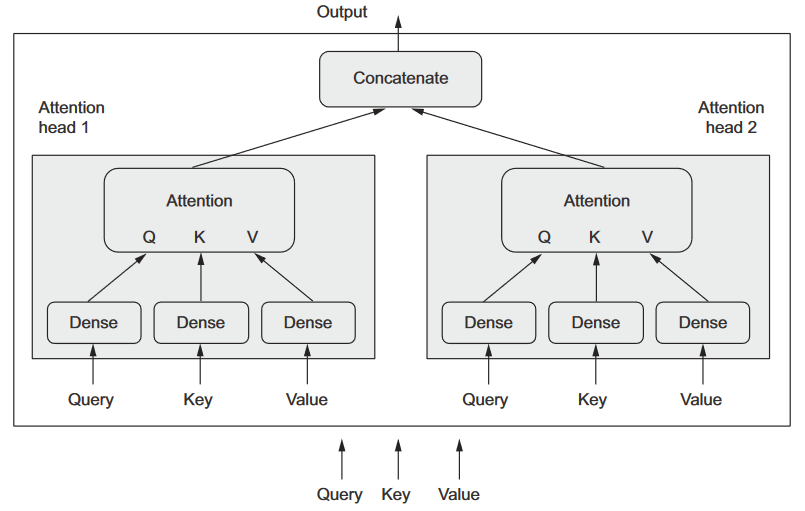

#### The Transformer encoder

If adding extra dense projections is so useful, why don’t we also apply one or two to the output of the attention mechanism? Actually, that’s a great idea—let’s do that.

And our model is starting to do a lot, so we might want to add residual connections to make sure we don’t destroy any valuable information along the way—you learned in chapter CNN that they’re a must for any sufficiently deep architecture. 

And there’s another thing you learned in CNN: normalization layers are supposed to help gradients flow better during backpropagation.

That’s roughly the thought process that I imagine unfolded in the minds of the inventors of the Transformer architecture at the time. 

Factoring outputs into multiple independent spaces, adding residual connections, adding normalization layers—all of
these are standard architecture patterns that one would be wise to leverage in any complex model. 

Together, these bells and whistles form the Transformer encoder—one of two critical parts that make up the Transformer architecture.

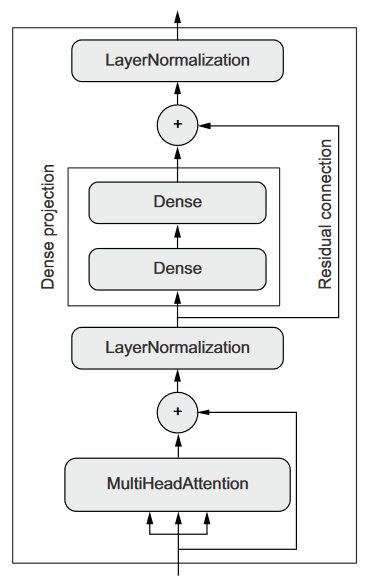

The original Transformer architecture consists of two parts: a Transformer encoder that processes the source sequence, and a Transformer decoder that uses the source sequence to generate a translated version. 

Crucially, the encoder part can be used for text classification—it’s a very generic module that ingests a sequence and learns to turn it into a more useful representation. 

Let’s implement a Transformer encoder and try it on the movie review sentiment classification task.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Transformer encoder implemented as a subclassed Layer

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Extra kwargs to the parent class
        super().__init__(**kwargs)
        
        # Size of the input token vectors
        self.embed_dim = embed_dim
        
        # Size of the inner dense layer
        self.dense_dim = dense_dim
        
        # Number of attention heads
        self.num_heads = num_heads
        
        # Multihead attention layer
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim)

        # Dense projection layer
        self.dense_proj = keras.Sequential(
            [layers.Dense(
                dense_dim,
                activation="relu"),
                layers.Dense(embed_dim),
                ]
        )

        # Two normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    # Computation goes in call
    def call(self, inputs, mask=None):
        # The mask that will be generated by the Embedding layer will be 2D
        # But the attention layer expects to be 3D or 4D, so we expand its rank
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Self attention layer
        attention_output = self.attention(
            inputs, 
            inputs,
            attention_mask=mask)
        
        # First normalization layer takes the input and output of the attention
        proj_input = self.layernorm_1(inputs + attention_output)
        
        # Dense projection layer takes output of the first normalization layer
        proj_output = self.dense_proj(proj_input)
        
        # Second normalization layer takes the output of the dense projection layer and output of the first normalization layer as residual connection
        return self.layernorm_2(proj_input + proj_output)
    
    # Implement serialization so we can save the model
    def get_config(self):
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config

When you write custom layers, make sure to implement the get_config method: this enables the layer to be reinstantiated from its config dict, which is useful during model saving and loading. The method should return a Python dict that contains the values of the constructor arguments used to create the layer.

All Keras layers can be serialized and deserialized as follows

```
# The config does not contain weight values, so all weights in the layer get initialized from scratch
config = layer.get_config()
new_layer = layer.__class__.from_config(config)
```

For instance:

```
layer = PositionalEmbedding(sequence_length, input_dim, output_dim)
config = layer.get_config()
new_layer = PositionalEmbedding.from_config(config)
```

When saving a model that contains custom layers, the savefile will contain these config dicts. 

When loading the model from the file, you should provide the custom layer classes to the loading process, so that it can make sense of the config objects.

```
model = keras.models.load_model(
filename, custom_objects={"PositionalEmbedding": PositionalEmbedding})
```

You’ll note that the normalization layers we’re using here aren’t BatchNormalization layers like those we’ve used before in image models. 

That’s because BatchNormalization doesn’t work well for sequence data. 

Instead, we’re using the LayerNormalization layer, which normalizes each sequence independently from other sequences in the batch.

While BatchNormalization collects information from many samples to obtain accurate statistics for the feature means and variances, LayerNormalization pools data within each sequence separately, which is more appropriate for sequence data.

Now that we’ve implemented our TransformerEncoder, we can use it to assemble a text-classification model similar to the GRU-based one you’ve seen previously.

In [3]:
# Using the Transformer encoder for text classification

vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# Since TransformerEncoder returns full sequences, we need to reduce each sequence to a single vector for classification via a global pooling layer
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [4]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [3]:
# Data

batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# Prepare a dataset  that only yields raw text inputs (no labels)
text_only_train_ds = train_ds.map(lambda x, y: x)

In [5]:
max_length = 600
max_tokens = 20000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    )

text_vectorization.adapt(text_only_train_ds)

In [6]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [10]:
# Training and evaluating the Transformer encoder based model

callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
    save_best_only=True)
    ]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=20,
callbacks=callbacks)

Epoch 1/20

  9/625 [..............................] - ETA: 22:57 - loss: 1.7779 - accuracy: 0.5243

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model(
    "transformer_encoder.keras",
    # Provide the custom TransformerEncoder class to the model-loading process
    custom_objects={"TransformerEncoder": TransformerEncoder})

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

It gets to 87.5% test accuracy—slightly worse than the GRU model.

**What's wrong here?**

At this point, you should start to feel a bit uneasy. Something’s off here. Can you tell what it is?

This section is ostensibly about “sequence models.” I started off by highlighting the importance of word order. I said that Transformer was a sequence-processing architecture, originally developed for machine translation. 

And yet . . . the Transformer encoder you just saw in action wasn’t a sequence model at all. Did you notice? 

It’s composed of dense layers that process sequence tokens independently from each other, and an attention layer that looks at the tokens as a set. 

You could change the order of the tokens in a sequence, and you’d get the exact same pairwise attention scores and the exact same context-aware representations. 

If you were to completely scramble the words in every movie review, the model wouldn’t notice, and you’d still get the exact same accuracy. 

Self-attention is a set-processing mechanism, focused on the relationships between pairs of sequence elements—it’s blind to whether these elements occur at the beginning, at the end, or in the middle of a sequence. 

So why do we say that Transformer is a sequence model? And how could it possibly be good for machine translation if it doesn’t look at word order?

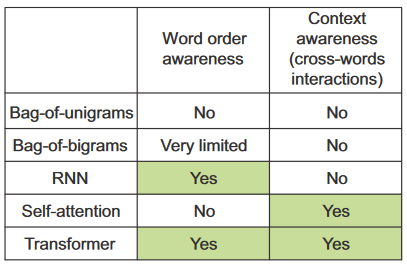

I mentioned that Transformer was a hybrid approach that is technically order-agnostic, but that manually injects order information in the representations it processes. This is the missing ingredient! It’s called positional encoding.

#### USING POSITIONAL ENCODING TO RE-INJECT ORDER INFORMATION

The idea behind positional encoding is very simple: to give the model access to word order information, we’re going to add the word’s position in the sentence to each word embedding.

Our input word embeddings will have two components: the usual word vector, which represents the word independently of any specific context, and a position vector, which represents the position of the word in the current sentence. Hopefully, the model will then figure out how to best leverage this additional information.

The simplest scheme you could come up with would be to concatenate the word’s position to its embedding vector. You’d add a “position” axis to the vector and fill it with 0 for the first word in the sequence, 1 for the second, and so on.

That may not be ideal, however, because the positions can potentially be very large integers, which will disrupt the range of values in the embedding vector. As you know, neural networks don’t like very large input values, or discrete input distributions.

The original “Attention is all you need” paper used an interesting trick to encode word positions: it added to the word embeddings a vector containing values in the range [-1, 1] that varied cyclically depending on the position (it used cosine func-
tions to achieve this). 

This trick offers a way to uniquely characterize any integer in a large range via a vector of small values. It’s clever, but it’s not what we’re going to use in our case. 

We’ll do something simpler and more effective: we’ll learn position embedding vectors the same way we learn to embed word indices. We’ll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. This technique is called “positional embedding.”

In [7]:
# Implementing positional embedding as a subclassed layer

class PositionalEmbedding(layers.Layer):
    # A downside of position embeddings is that the sequence length needs to be known in advance
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepare an Embedding layer for the token indices
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim,
            output_dim=output_dim)
        
        # Positonal embeddings
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, 
            output_dim=output_dim)
        
        # Sequence length, input and output dim
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self, inputs):
        # Length of input
        length = tf.shape(inputs)[-1]
        
        # Defining positions as range
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Token embeddings getting inputs
        embedded_tokens = self.token_embeddings(inputs)
        
        # Positional embedding getting positions
        embedded_positions = self.position_embeddings(positions)

        # Add both embedding vectors together
        return embedded_tokens + embedded_positions
    
    # Like the Embedding layer, this layer should be able to generate a mask so we can ignore padding 0s in the inputs
    # The compute_mask method will called automatically by the framework, and the mask will get propagated to the next layer
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    # Implement serialization so we can save the model
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            })
        return config

You would use this PositionEmbedding layer just like a regular Embedding layer.

#### PUTTING IT ALL TOGETHER: A TEXT-CLASSIFICATION TRANSFORMER 

All you have to do to start taking word order into account is swap the old Embedding layer with our position-aware version.

In [8]:
# Combining the Transformer encoder with positional embedding

vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [9]:
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 256)         5273600   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                            

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
                                    ]

model.fit(int_train_ds, 
          validation_data=int_val_ds, 
          epochs=20,
          callbacks=callbacks)

Epoch 1/20

 18/625 [..............................] - ETA: 22:09 - loss: 1.5033 - accuracy: 0.4861

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

We get to 88.3% test accuracy, a solid improvement that clearly demonstrates the value of word order information for text classification. 

This is our best sequence model so far! However, it’s still one notch below the bag-of-words approach.

**When to use sequence models over bag-of-words models**

You may sometimes hear that bag-of-words methods are outdated, and that Transformer-based sequence models are the way to go, no matter what task or dataset you’re looking at. 

This is definitely not the case: a small stack of Dense layers on top of a bag-of-bigrams remains a perfectly valid and relevant approach in many cases. 

In fact, among the various techniques that we’ve tried on the IMDB dataset throughout this chapter, the best performing so far was the bag-of-bigrams!

**So, when should you prefer one approach over the other?**

In 2017, Francois Chollet and team ran a systematic analysis of the performance of various text-classification techniques across many different types of text datasets, and we discovered a remarkable and surprising rule of thumb for deciding whether to go with a bag-of-words model or a sequence model (http://mng.bz/AOzK)—a golden constant of sorts.

It turns out that when approaching a new text-classification task, you should pay close attention to the ratio between the number of samples in your training data and the mean number of words per sample. 

If that ratio is small—less than 1,500—then the bag-of-bigrams model will perform better (and as a bonus, it will be much faster to train and to iterate on too). 

If that ratio is higher than 1,500, then you should go with a sequence model. In other words, sequence models work best when lots of training data is available and when each sample is relatively short.

So if you’re classifying 1,000-word long documents, and you have 100,000 of them (a ratio of 100), you should go with a bigram model. 

If you’re classifying tweets that are 40 words long on average, and you have 50,000 of them (a ratio of 1,250), you should
also go with a bigram model. 

But if you increase your dataset size to 500,000 tweets (a ratio of 12,500), go with a Transformer encoder. 

What about the IMDB movie review classification task? We had 20,000 training samples and an average word count of 233, so our rule of thumb points toward a bigram model, which confirms what we found in practice.

This intuitively makes sense: the input of a sequence model represents a richer and more complex space, and thus it takes more data to map out that space; mean-while, a plain set of terms is a space so simple that you can train a logistic regression
on top using just a few hundreds or thousands of samples. 

In addition, the shorter a sample is, the less the model can afford to discard any of the information it contains—in particular, word order becomes more important, and discarding it can create ambiguity. 

The sentences “this movie is the bomb” and “this movie was a bomb” have very close unigram representations, which could confuse a bag-of-words model, but a sequence model could tell which one is negative and which one is positive.

With a longer sample, word statistics would become more reliable and the topic or sentiment would be more apparent from the word histogram alone.

Keep in mind that this heuristic rule was developed specifically for text classification. It may not necessarily hold for other NLP tasks—when it comes to machine translation, for instance, Transformer shines especially for very long sequences, compared to RNNs. This heuristic is also just a rule of thumb, rather than a scientific law, so expect it to work most of the time, but not necessarily every time.